In [166]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/time-machine/timemachine.txt


1. Load text as strings into memory.

2. Split the strings into tokens (e.g., words or characters).

3. Build a vocabulary dictionary to associate each vocabulary element with a numerical index.

4. Convert the text into sequences of numerical indices

In [167]:
import collections 
import re
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F

In [168]:
with open('/kaggle/input/time-machine/timemachine.txt',"r") as f:
    txt = f.read()

In [169]:
class Vocab:
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        #count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x:x[1], reverse=True)
        
        #list of unique tokens
        self.itos = list(sorted(set(['<unk>'] + reserved_tokens + [token for token, freq in self.token_freqs if freq >= min_freq])))
        self.stoi = {token: idx for idx,token in enumerate(self.itos) }
        
    def __len__(self):
        #length of vocabulary
        return len(self.itos)
    
    def __getitem__(self, tokens):
        #make tokens into indices
        if not isinstance(tokens,(list,tuple)):
            return self.stoi[tokens]
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self,indices):
        #make indixes into tokens
        if hasattr(indices,'__len__') and len(indices)>1:
            return [self.itos[int(index)] for index in indices]
        return slef.itos[indices]
    
    @property
    def unk(self):
        return self.token_to_idx['<unk>']

In [170]:
class text_dataset(Dataset):
    def __init__(self, num_steps,train= True, train_size=10000, val_size=5000):
        super().__init__()
        corpus,self.vocab = self.build(self._load())
        array = torch.tensor([corpus[i:i+num_steps+1] for i in range(len(corpus)-num_steps)])
        if train:
            self.X,self.Y = array[:,:-1][:train_size],array[:,1:][:train_size]
        else:
            self.X,self.Y = array[:,:-1][train_size:train_size+val_size],array[:,1:][train_size:train_size+val_size]
        
    def _load(self,path= '/kaggle/input/time-machine/timemachine.txt'):
        with open(path,"r") as f:
            return f.read()
        
    def _preprocess(self, raw_text):
        return re.sub('[^A-Za-z]+',' ',raw_text).lower()
    
    def _tokenize(self,text):
        return list(text)
    
    def build(self,raw_text,vocab=None):
        tokens = self._tokenize(self._preprocess(raw_text))
        if vocab is None: vocab = Vocab(tokens)
        corpus = [vocab[token] for token in tokens]
        return corpus, vocab
    
    def __getitem__(self,index):
        sample = self.X[index],self.Y[index]
        return sample
    
    def __len__(self):
        return self.X.shape[0]


In [171]:
train_data = text_dataset(num_steps=32,train=True)
test_data = text_dataset(num_steps=32,train=False)

In [172]:
train_data[-1]

(tensor([ 0,  2, 15,  5,  0, 20, 16, 14,  6,  0, 21, 19,  2, 15, 20, 17,  2, 19,
          6, 15, 21,  0,  4, 19, 26, 20, 21,  2, 13, 13, 10, 15]),
 tensor([ 2, 15,  5,  0, 20, 16, 14,  6,  0, 21, 19,  2, 15, 20, 17,  2, 19,  6,
         15, 21,  0,  4, 19, 26, 20, 21,  2, 13, 13, 10, 15,  6]))

In [173]:
test_data[0]

(tensor([ 2, 15,  5,  0, 20, 16, 14,  6,  0, 21, 19,  2, 15, 20, 17,  2, 19,  6,
         15, 21,  0,  4, 19, 26, 20, 21,  2, 13, 13, 10, 15,  6]),
 tensor([15,  5,  0, 20, 16, 14,  6,  0, 21, 19,  2, 15, 20, 17,  2, 19,  6, 15,
         21,  0,  4, 19, 26, 20, 21,  2, 13, 13, 10, 15,  6,  0]))

In [174]:
train_loader = DataLoader(dataset=train_data,batch_size=1024,shuffle=True)
test_loader = DataLoader(dataset=test_data,batch_size=1024,shuffle=True)

In [175]:
samples,labels = next(iter(train_loader))

In [176]:
samples.shape,labels.shape

(torch.Size([1024, 32]), torch.Size([1024, 32]))

A language model predicts the probability of a sequence\
$ P(x_1, x_2, \ldots, x_T),$\
language model may tell that "i want to eat grandma" is less probable than "i want to eat,grandma"

perplexity:\
$exp(\frac{1}{n} \sum_{t=1}^n -\log P(x_t \mid x_{t-1}, \ldots, x_1))$\
average of probablity of the next token in the actual sequence as predicted by the model

making tokens of size n:\
each epoch discard the first z~unif0,n) tokens\
make it into sample of length n s.t the you start at d and sample subsequences.


9.4-|v|^n b/c storing  larger length subsequence

$P(x_t \mid x_{t-1}, \ldots, x_1) \approx P(x_t \mid h_{t-1})$\
the RNN hidden state is like the approximation of history\
X_t is a R^nxd implies the t th token (token at timestep t) for minibatches
$\mathbf{H}_t = \phi(\mathbf{X}_t \mathbf{W}_{\textrm{xh}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hh}}  + \mathbf{b}_\textrm{h})$\
$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{\textrm{hq}} + \mathbf{b}_\textrm{q}$

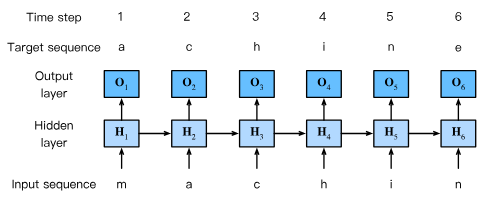

nn.Parameters(data=None,requires_grad=True)

In [177]:
class RNNscrach(nn.Module):
    def __init__(self,input_size,hidden_size,sigma=0.01):
        '''
        num_input: size of input tokens
        num_hidden: size if hidden state
        '''
        super().__init__()
        self.sigma = sigma
        self.hidden_size = hidden_size
        self.W_xh = nn.Parameter(torch.randn(input_size, hidden_size)*sigma)
        self.W_hh = nn.Parameter(torch.randn(hidden_size, hidden_size)*sigma)
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
        
    def forward(self,inputs,state=None):
        '''
        inputs: shape (num_steps,batch_size,num_inputs)
        '''
        if state is None:
            state = torch.zeros((inputs.shape[1],self.hidden_size),device=inputs.device)
        else:
            state = state
        outputs = []
        for X in inputs:
            #iterates time step wise
            state = torch.tanh(torch.matmul(X, self.W_xh) + 
                              torch.matmul(state,self.W_hh) + self.b_h)
            outputs.append(state)
        return outputs,state

In [178]:
# y = torch.randn(4,4,1)
# print(y)
# for x in y:
#     print(x)

In [179]:
batch_size, input_size, hidden_size, num_steps = 2, 16, 32, 100
rnn = RNNscrach(num_inputs,hidden_size)
x = torch.ones((num_steps, batch_size, input_size))
outputs,state = rnn(x)

In [180]:
print(len(outputs) == num_steps)
state.shape == (batch_size,hidden_size)

True


True

In [241]:
class RNNLMscrach(nn.Module):
    '''language model based on RNN'''
    def __init__(self, rnn, vocab_size, clip_value=100.0):
        super().__init__()
        self.rnn = rnn
        self.vocab_size = vocab_size
        self.clip_value = clip_value
#         self.lr = lr
        self.W_hq = nn.Parameter(torch.randn(self.rnn.hidden_size,vocab_size)*self.rnn.sigma)
    #the output size set to be vocab_size
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))
        
    def one_hot(self,X):
        return F.one_hot(X.T, self.vocab_size).type(torch.float32)
    
    def output_layer(self,rnn_outputs):
        outputs = [torch.matmul(H,self.W_hq) + self.b_q for H in rnn_outputs]
        return torch.stack(outputs, 1)#num_steps,batch_size,vocab_size
        
    def forward(self,X,state=None):
        '''
        X:batch_size,time_step
        '''
        embs = self.one_hot(X)
        # embs.shape:timesteps,batch_size,embedding_dimension
        rnn_outputs,_ = self.rnn(embs,state)
        return self.output_layer(rnn_outputs)
        
    def clip_gradient(self):
        norm = 0
        for parameter in self.parameters():
            if parameter.requires_grad:
                norm += torch.sum(parameter.grad**2)
            norm = torch.sqrt(norm)
        if norm > self.clip_value:
            for param in self.parameters():
                param.grad*=self.clip_value/norm
    def generate(self,prefix,num_preds,vocab,device = "cuda" if torch.cuda.is_available() else "cpu"):
        state,outputs = None,[vocab[prefix[0]]]#2D array that batch_size,1(index of prefix[0])
        for i in range(len(prefix) + num_preds - 1):
            X = torch.tensor([[outputs[-1]]],device=device)
            embs = self.token_embd(X)
            rnn_outputs, state = self.rnn(embs,state)
            if i < len(prefix) - 1:
                outputs.append(vocab[prefix[i+1]])
            else:
                Y = self.output_layer(rnn_outputs)
                outputs.append(int(Y.argmax(axis=2).reshape(1)))
        return ''.join([vocab.itos[i] for i in outputs])

why one hot encoding?\
you may try to feed the index as inputs but the close indices may not be remotely similar in meaning.
- after doing one hot encoding it goes from:\
batch_size,num_steps-->num_steps,batch_size-->num_steps,batch_size,|v|

F.one_hot:\
[[0,1],[2,0]]-->\
[[[1,0,0],[0,1,0]],[[0,0,1],[1,0,0]]]

torch.stack(list):
```
import torch

tensor1 = torch.randn(4, 5)  # Shape: 4x5
tensor2 = torch.randn(4, 5)  # Shape: 4x5
tensor3 = torch.randn(4, 5)  # Shape: 4x5

list_of_tensors = [tensor1, tensor2, tensor3]

stacked_tensor = torch.stack(list_of_tensors, 1)

print(stacked_tensor.shape)  # Output: torch.Size([4, 3, 5])
```

In [182]:
tensor1 = torch.randn(4, 5)  # Shape: 4x5
tensor2 = torch.randn(4, 5)  # Shape: 4x5
tensor3 = torch.randn(4, 5)  # Shape: 4x5
print(tensor1,tensor2,tensor3)
list_of_tensors = [tensor1, tensor2, tensor3]

stacked_tensor = torch.stack(list_of_tensors, 1)

print(stacked_tensor)  

tensor([[-0.7861, -1.0385,  0.2893, -0.3616, -1.7405],
        [-0.1998,  0.1163,  1.0202,  0.2310, -0.7437],
        [-1.8071, -0.3671, -0.2501, -0.8537,  0.5127],
        [ 0.1397,  1.4585, -2.0581, -0.8796,  1.0938]]) tensor([[ 1.2852e+00,  1.5241e-03, -2.6318e-01,  1.4923e+00,  1.8825e+00],
        [-3.0074e-01, -1.1727e+00,  2.4738e+00, -8.5257e-01, -1.3372e-01],
        [ 2.3629e+00, -6.3944e-01,  3.5097e-01,  9.6859e-01, -2.9261e-02],
        [ 5.7588e-01, -4.7455e-01, -2.9137e-01,  1.5688e+00, -3.9584e-02]]) tensor([[-0.1936, -0.2966,  0.9423,  0.1863,  0.6916],
        [-0.7502, -0.2274,  0.1436,  0.1031,  0.0346],
        [-1.8975,  0.5387, -0.9364, -0.7925,  0.1992],
        [ 0.9217,  1.5563,  0.3821, -0.0488, -0.5879]])
tensor([[[-7.8609e-01, -1.0385e+00,  2.8934e-01, -3.6163e-01, -1.7405e+00],
         [ 1.2852e+00,  1.5241e-03, -2.6318e-01,  1.4923e+00,  1.8825e+00],
         [-1.9357e-01, -2.9658e-01,  9.4228e-01,  1.8626e-01,  6.9162e-01]],

        [[-1.9980e-01,  1.1

In [183]:
# model = RNNLMscrach(rnn, input_size)#this decodes to a size same as the input
# outputs = model(torch.ones((batch_size,num_steps),dtype=torch.int64))
# outputs.shape

In [242]:
rnn = RNNscrach(input_size=len(train_data.vocab),hidden_size=32)
model = RNNLMscrach(rnn,vocab_size=len(train_data.vocab) )#this decodes to a size same as the input

In [235]:
for i in model.parameters():
    print(i.shape)

torch.Size([32, 28])
torch.Size([28])
torch.Size([28, 32])
torch.Size([32, 32])
torch.Size([32])


In [236]:
len(train_data.vocab)

28

In [237]:
lr = 1
num_epochs = 100
optimizer = torch.optim.AdamW(model.parameters(),lr=lr)

In [238]:
for epoch in range(num_epochs):    
    for i,(sample,targets) in enumerate(train_loader):
        out = model(sample)
        #out.shape:num_steps,batch_size,channel/vocab
        num_steps,batch_size,vocab_size = out.shape
        out = out.view(num_steps*batch_size,-1)
        targets = targets.view(num_steps*batch_size,)
#         if i==0:
#             print(out.shape,targets.shape)
#             break
        loss = F.cross_entropy(out,targets)
        optimizer.zero_grad()
        loss.backward()
#         model.clip_gradient()
        optimizer.step() 

KeyboardInterrupt: 

In [239]:
loss.item()

2.7118725776672363

In [243]:
model.generate('father is using mobile', 20, train_data.vocab)

'father is using mobile                    '

In [191]:
a=torch.tensor([[1,0,0],[0,1,0]])

In [192]:
torch.max(a,dim=1)

torch.return_types.max(
values=tensor([1, 1]),
indices=tensor([0, 1]))

In [193]:
a=[[1]]

In [194]:
a[-1]

[1]

warmup:\
when beginning prediction start by passing the 'prefix' one by one into the rnn and start predicting from the last prefix token output till the required length.\


lipschitz conts:\
$|f(\mathbf{x}) - f(\mathbf{y})| \leq L \|\mathbf{x} - \mathbf{y}\|.
$\
gradient clipping:\
$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}$

exercise:\
9


In [264]:
class RNNLMembd(nn.Module):
    '''language model based on RNN'''
    def __init__(self, rnn, vocab_size, clip_value=100.0):
        super().__init__()
        self.rnn = rnn
        self.vocab_size = vocab_size
        self.clip_value = clip_value
        self.token_embd = nn.Embedding(vocab_size,rnn.hidden_size)
#         self.lr = lr
        self.W_hq = nn.Parameter(torch.randn(self.rnn.hidden_size,vocab_size)*self.rnn.sigma)
    #the output size set to be vocab_size
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))
        
#     def one_hot(self,X):
#         return F.one_hot(X.T, self.vocab_size).type(torch.float32)
    
    def output_layer(self,rnn_outputs):
        outputs = [torch.matmul(H,self.W_hq) + self.b_q for H in rnn_outputs]
        return torch.stack(outputs, 1)#num_steps,batch_size,vocab_size
        
    def forward(self,X,state=None):
        '''
        X:batch_size,time_step
        '''
        embs = self.token_embd(X.T)
        # embs.shape:timesteps,batch_size,embedding_dimension
        rnn_outputs,_ = self.rnn(embs,state)
        return self.output_layer(rnn_outputs)
        
    def clip_gradient(self):
        norm = 0
        for parameter in self.parameters():
            if parameter.requires_grad:
                norm += torch.sum(parameter.grad**2)
            norm = torch.sqrt(norm)
        if norm > self.clip_value:
            for param in self.parameters():
                param.grad*=self.clip_value/norm
    def generate(self,prefix,num_preds,vocab,device = "cuda" if torch.cuda.is_available() else "cpu"):
        state,outputs = None,[vocab[prefix[0]]]#2D array that batch_size,1(index of prefix[0])
        for i in range(len(prefix) + num_preds - 1):
            X = torch.tensor([[outputs[-1]]],device=device)
            embs = self.token_embd(X)
            rnn_outputs, state = self.rnn(embs,state)
            if i < len(prefix) - 1:
                outputs.append(vocab[prefix[i+1]])
            else:
                Y = self.output_layer(rnn_outputs)
                probs = F.softmax(Y,dim=2)
                outputs.append(int(torch.multinomial(probs[0,0,:],num_samples=1).reshape(1)))
        return ''.join([vocab.itos[i] for i in outputs])

In [265]:
class RNNembd(nn.Module):
    def __init__(self,input_size,hidden_size,sigma=0.01):
        '''
        num_input: size of input tokens
        num_hidden: size if hidden state
        '''
        super().__init__()
        self.sigma = sigma
        self.hidden_size = hidden_size
#         self.W_xh = nn.Parameter(torch.randn(input_size, hidden_size)*sigma)
        self.W_hh = nn.Parameter(torch.randn(hidden_size, hidden_size)*sigma)
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
        
    def forward(self,inputs,state=None):
        '''
        inputs: shape (num_steps,batch_size,num_inputs)
        '''
        if state is None:
            state = torch.zeros((inputs.shape[1],self.hidden_size),device=inputs.device)
        else:
            state = state
        outputs = []
        for X in inputs:
            #iterates time step wise
            state = torch.tanh(X + 
                              torch.matmul(state,self.W_hh) + self.b_h)
            outputs.append(state)
        return outputs,state

In [266]:
rnn = RNNembd(input_size=len(train_data.vocab),hidden_size=32)
model = RNNLMembd(rnn,vocab_size=len(train_data.vocab) )#this decodes to a size same as the input

In [267]:
for i in model.parameters():
    print(i.shape)

torch.Size([32, 28])
torch.Size([28])
torch.Size([32, 32])
torch.Size([32])
torch.Size([28, 32])


In [268]:
len(train_data.vocab)

28

In [269]:
lr = 1e-2
num_epochs = 100
optimizer = torch.optim.AdamW(model.parameters(),lr=lr)

In [270]:
for epoch in range(num_epochs):    
    for i,(sample,targets) in enumerate(train_loader):
        out = model(sample)
        #out.shape:num_steps,batch_size,channel/vocab
        num_steps,batch_size,vocab_size = out.shape
        out = out.view(num_steps*batch_size,-1)
        targets = targets.view(num_steps*batch_size,)
#         if i==0:
#             print(out.shape,targets.shape)
#             break
        loss = F.cross_entropy(out,targets)
        optimizer.zero_grad()
        loss.backward()
        model.clip_gradient()
        optimizer.step() 

In [271]:
loss.item()

1.448016881942749

In [272]:
model.generate('father is using mobile', 20, train_data.vocab)

'father is using mobiled the weacen theng t'